# Distances

Ieasuring the distance or similarity between time series is a key primitive operation
 in a range of time series machine learning tasks. This notebook describes the core
 distance functionality available in aeon, focusing on two key distance measures,
 Euclidean distance and dynamic time warping. We describe the full range of distance
 functions available in [distances notebook](examples/distances/elastic_distances.ipynb) and show how they
  can be used with
 aeon and scikit-learn estimators in [here](examples/distances/sklearn_distances.ipynb).


The goal of a distance computation is to measure the dis-similarity between the time
series `a` and `b`. A distance function should take `a` and `b` as parameters and return
a float that is the computed distance between `a` and `b`. The value returned should
be `0
.0` when the time series are exactly the same, and, when they are different, a value
greater than `0.0` that is a measure of distance between them.

Distance functions can be used in all time series machine learning tasks. In
[classification](examples/classification/distance_based.py) and [regression](examples/regression/distance_based.py) they are
employed in, for example nearest neighbour classifiers/regressors. In [clustering](examples/clustering/distance_based.py) they are central to $k$-means and $k$-medoids clustering.


This notebook provides a simple use case for distances and motivates why we need elastic
 distances. It introduces the most popular elastic distance measure, dynamic time
 warping, and describes how it is used and parameterised in aeon. We show how
 to retrieve all pairwise distances for a collection of series and how to use
 distances with multivariate time series distances. Distances can be used to find
 alignment paths, and this functionality is described [here](e


## Simple use case for distances

distance functions take two 1D or 2D numpy array input and calculate a distance. If a
 series has more than one channel (i.e. multivariate time series), it should be stored
  as shape `(d,n)`. Univariate time series of length $n$ can be modelled as either
  shape `(n,)` or `(1,n)`. The simplest distance is Euclidean distance. This measures the sum of squared
distances between points.

$$d_e(a, b) = \sqrt{\sum_{i=1}^m(a_i-b_i)}$$.

The most popular time series specific distance is dynamic time warping (DTW). These
and other distance functions are imported form aeon.distances.

In [1]:
import numpy as np

from aeon.distances import dtw_distance, euclidean_distance

a = np.array([1, 2, 3, 4, 5, 6])  # Univariate as 1D
b = np.array([2, 3, 4, 5, 6, 7])
d1 = euclidean_distance(a, b)
d2 = dtw_distance(a, b)
print(f" ED 1 = {d1} DTW 1 = {d2}")
x = np.array([[1, 2, 3, 4, 5, 6]])  # Univariate as 2D
y = np.array([[2, 3, 4, 5, 6, 7]])
d1 = euclidean_distance(x, y)
d2 = dtw_distance(x, y)
print(f" ED 2 = {d1} DTW 2 = {d2}")
x = np.array([[1, 2, 3, 4, 5, 6], [3, 4, 3, 4, 3, 4]])  # Multivariate, 2 channels
y = np.array([[2, 3, 4, 5, 6, 7], [7, 6, 5, 4, 3, 2]])
d1 = euclidean_distance(x, y)
d2 = dtw_distance(x, y)
print(f" ED 3 = {d1} DTW 3 = {d2}")

 ED 1 = 2.449489742783178 DTW 1 = 2.0
 ED 2 = 2.449489742783178 DTW 2 = 2.0
 ED 3 = 5.830951894845301 DTW 3 = 34.0


## Basic Motivation for Elastic Distances

As an example we will use data from the gunpoint data. This is a two class problem.
If a distance function is to be useful, we hope it will measure lower distances between
instances of the same class than those of different classes. We extract three cases
as an example.

(200, 1, 150)
 class values 2, 1, 2


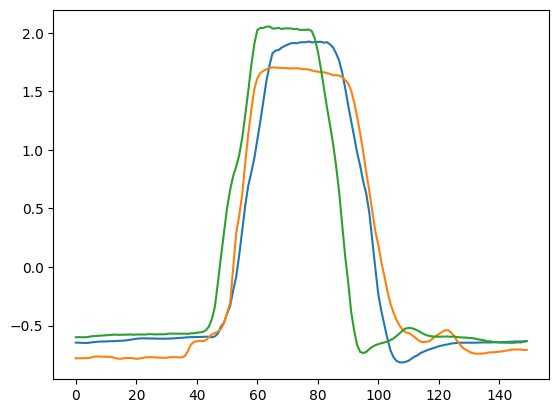

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from aeon.datasets import load_gunpoint

X, y = load_gunpoint()
print(X.shape)
first = X[1][0]
second = X[2][0]
third = X[4][0]
plt.plot(first)
plt.plot(second)
plt.plot(third)
print(f" class values {y[1]}, {y[2]}, {y[4]}")

 The problem with Euclidean distance is it takes no account
of the order, and so a small offset can lead to large distances. For this problem,
the discriminatory information is in the small areas before and after the peak
(around points 30-50 and 100-130). In the example
above, the first and third example are in the same class, but the peaks are
offset. This means there is a larger distance between these cases and the second
example. Note that you can also find distances by calling `distance` with a string
parameter for the distance like so:

In [3]:
from aeon.distances import distance, euclidean_distance

d1 = euclidean_distance(first, second)
d2 = euclidean_distance(first, third)
d3 = distance(second, third, metric="euclidean")
print(d1, ",", d2, ",", d3)

2.490586847171778 , 6.307592298519925 , 6.618889405616554


Elastic distances such dynamic time warping realign series to compensate for offset.
If we use `dtw_distance` instead of `euclidean_distance`

In [4]:
from aeon.distances import dtw_distance

d1 = dtw_distance(first, second)
d2 = dtw_distance(first, third)
d3 = dtw_distance(second, third)
print(d1, ",", d2, ",", d3)

1.733128174164524 , 0.5299968542651227 , 3.666430398991013


we see now the first example is closer to the one in its own class than the second
example.

#### Dynamic time warping
Dynamic time warping (DTW) [2] is an elastic distance measure that works by first
calculating all the ($m,m$ square pointwise distance matrix $M$ between all points in
 the series, $ M_{i,j}(a,b) = (a_i-b_j)^2 $ then using $M$ to find the minimum
 path through this matrix to minimise the total cost of traversal, allowing movement
 forward of one square at a time. For following algorithm includes a bounding matrix
 (see below).

<img src="./img/dtw_algo.png" width="600">

The warping path can be seen as the path of least resistance through the cost matrix
`C` found throug a dynamic programming formulation.

<img src="./img/dtw_vis.png" width="600">



### Custom parameters for distances

Each distance function has a different set of parameters. For specific parameters for
 each distance please refer to the documentation and the [distance function notebook](examples/distances/distance_functions.ipynb).


DTW is a $O(n^2)$ algorithm and as such a point of focus has been trying to optimise the
algorithm. A proposal to improve performance is to restrict the potential alignment
path by putting a 'bound' on values to consider when looking for an alignment. While
there have been many bounding algorithms proposed the most popular is known as
Sakoe-Chiba's bounding window.

This is implemented in aeon using a bounding box mask, where False indicates an
invalid move. The bounding matrix that considers all
indexes in `a` and `b`:

In [5]:
from aeon.distances import create_bounding_matrix

first_ts_size = 10
second_ts_size = 10

create_bounding_matrix(first_ts_size, second_ts_size)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

Above shows a matrix that maps each index in 'a' to each index in 'b'. Each value
that is considered in the computation is set to True (in this instance we want a full
bounding matrix so all values are set to True). This means we can warp any index
onto another.

However, it sometimes (depending on the dataset) is not necessary (and sometimes
detrimental to the result) to consider all indexes. We can use a bounding technique
like Sakoe-Chibas to limit the potential warping paths. This is done by setting a window
size that will restrict the indexes that are considered. Below shows creating a bounding
matrix again but only considering 20% of the indexes in x and y:

In [6]:
create_bounding_matrix(first_ts_size, second_ts_size, window=0.2)

array([[ True,  True,  True, False, False, False, False, False, False,
        False],
       [ True,  True,  True,  True, False, False, False, False, False,
        False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False],
       [False,  True,  True,  True,  True,  True, False, False, False,
        False],
       [False, False,  True,  True,  True,  True,  True, False, False,
        False],
       [False, False, False,  True,  True,  True,  True,  True, False,
        False],
       [False, False, False, False,  True,  True,  True,  True,  True,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False,  True,  True,
         True]])

This bounding matrix produces a corridor of allowed warping. A nice visualisation of DTW with a constained window from https://github.com/hadifawaz1999/DTW_GUI

<img src="./img/DTW_GUI_warped.gif" width="600">

From a users perspective, the easiest way to constrain DTW
 with a bounding window is to set the parameter `window`, which sets the maximum
 percentage of series length of warping allowed. No window (`window=0.0`)
 corresponds to the squared Euclidean distance. The default value is full window
 (`window=1.0`) which means full warping. A common default setting is to use
 `window=0.2` and this is often referred to as
 constrained DTW (cdtw).

Note that we do not take the square root of DTW, because it is not necessary for any
of the applications used in aeon, which require ordering time series by distances.


Euclidean distance a to b = 8.12403840463596
Euclidean distance a to c = 5.916079783099616
Zero window DTW distance (Squared Euclidean) from a to b = 66.0
Squared Euclidean =  66.00000000000001
DTW distance (full window) a to b = 1.0
DTW distance (20% warping window) a to b = 1.0


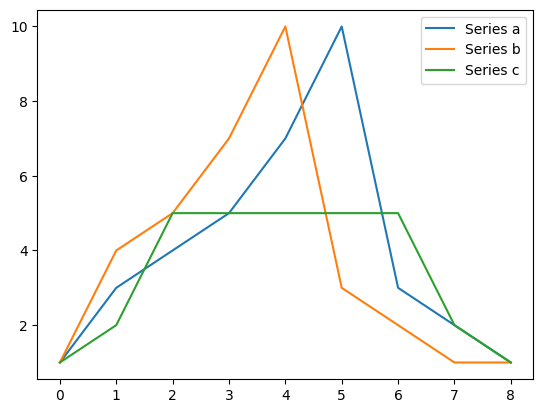

In [7]:
a = np.array([1, 3, 4, 5, 7, 10, 3, 2, 1])
b = np.array([1, 4, 5, 7, 10, 3, 2, 1, 1])
c = np.array([1, 2, 5, 5, 5, 5, 5, 2, 1])
plt.plot(a, label="Series a")
plt.plot(b, label="Series b")
plt.plot(c, label="Series c")
plt.legend()
d1 = euclidean_distance(a, b)
d2 = euclidean_distance(a, c)
print("Euclidean distance a to b =", d1)
print("Euclidean distance a to c =", d2)
d1 = dtw_distance(a, b, window=0.0)
d2 = dtw_distance(a, b, window=1.0)
d3 = dtw_distance(a, b, window=0.2)
d4 = euclidean_distance(a, b) ** 2
print("Zero window DTW distance (Squared Euclidean) from a to b =", d1)
print("Squared Euclidean = ", d4)
print("DTW distance (full window) a to b =", d2)
print("DTW distance (20% warping window) a to b =", d3)

## Pairwise distances

It is common to want a matrix of pairwise distances for a collation of time series.
For example, medoid based clustering and certain sklearn estimators can work directly
 with distance functions. It is easy to get a pairwise distance function in aeon.
 This can either be for a single collection or for two collections. This is useful
 with [sklearn](examples/distances/sklearn_distances.ipynb)

In [8]:
from aeon.datasets import load_arrow_head
from aeon.distances import msm_pairwise_distance

X_train, _ = load_arrow_head(split="train")
X_test, _ = load_arrow_head(split="test")
X1 = X_train[:5]
X2 = X_test[:6]
train_dist_matrix = msm_pairwise_distance(X1)
test_dist_matrix = msm_pairwise_distance(X1, X2)
print(
    f"Single X dist pairwise is square and symmetrical shape "
    f"= {train_dist_matrix.shape}\n{train_dist_matrix}"
)
print(
    f"Two X dist pairwise is all dists from X1 (row) to X2 (column), so shape "
    f"shape = {test_dist_matrix.shape}\n{test_dist_matrix}"
)

Single X dist pairwise is square and symmetrical shape = (5, 5)
[[ 0.         62.2553732  45.91702356 49.72138985 50.07185968]
 [62.2553732   0.         31.06762179 93.31791099 25.73406576]
 [45.91702356 31.06762179  0.         82.05754675 32.71868983]
 [49.72138985 93.31791099 82.05754675  0.         79.50156797]
 [50.07185968 25.73406576 32.71868983 79.50156797  0.        ]]
Two X dist pairwise is all dists from X1 (row) to X2 (column), so shape shape = (5, 6)
[[ 21.01701605  22.16699488  86.45534374  75.69573009  48.79410225
   33.27495124]
 [ 63.76668286  59.61188967  93.89293437 109.6967054   92.68370785
   47.78485799]
 [ 44.01308016  39.55587095  99.06160623  94.98620404  85.33606252
   34.36027177]
 [ 53.21801989  60.05103978  72.37115291  64.11310795  24.86221373
   66.65632674]
 [ 48.70558166  48.82369739  88.5358956  101.44412148  80.20208926
   37.59557677]]


## Alignment paths

When elastic distances are calculated, they effectively align the two indexes. You can directly recover the warping path (or alignment paths)


In [9]:
from aeon.distances import alignment_path, dtw_alignment_path

x = np.array([[1, 2, 3, 4, 5, 6]])  # Univariate as 2D
y = np.array([[2, 3, 4, 5, 6, 7]])
p, d = dtw_alignment_path(x, y)
print("path =", p, " distance = ", d)
p, d = alignment_path(x, y, metric="dtw")
print("path =", p, " distance = ", d)

path = [(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (5, 5)]  distance =  2.0
path = [(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (5, 5)]  distance =  2.0


## Multivariate distances

aeon models a single multivariate time series as 2D numpy arrays of shape
`(n_channels, n_timepoints)`. Note we only support multivariate instances where each
 channel is the same length, and we assume they are aligned. Basic motions is a data
 set recording the (x,y,z) trace of motions taken from a smart watch

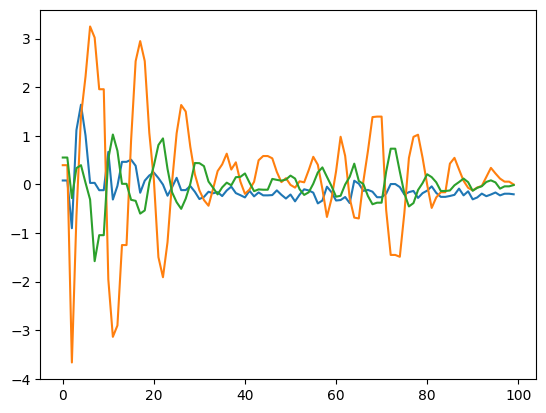

In [10]:
from aeon.datasets import load_basic_motions

motions, _ = load_basic_motions()
plt.plot(motions[0][0])
plt.plot(motions[0][1])
plt.plot(motions[0][2])

Suppose we have $k$ channels in our multivariate time series. There are two ways to
find the distance between two time series $a$ and $b$ of shape $(c,m)$.

1. Independent: we find the distance between each channel independently, then sum
them to get the final distance. So if we are using univariate distance $d$, the
multivariate version is $d_m(a,b) = \sum_{c=1}^k d(a_c, b_c)$.

2. Dependent: We use all channels during the calculation of the pointwise distance
matrix $M$, so that $M_{i,j}(a,b) = \sum_\sum_{c=1}^k (a_{c,i}-b_{c,j})^2$. The
distance then is calculated as before using this version of $M$.

`aeon` assumes the dependent approach. It is simple to get an independent version by
iterating over dimensions.

In [11]:
d1 = dtw_distance(motions[0], motions[1])
print("Dependent DTW distance (multivariate) motions[0] to motions[1] =", d1)
s = 0
for k in range(motions[0].shape[0]):
    s += dtw_distance(motions[0][k], motions[1][k])
print("Independent DTW distance (multivariate) motions[0] to motions[1] =", s)

Dependent DTW distance (multivariate) motions[0] to motions[1] = 330.83449721446283
Independent DTW distance (multivariate) motions[0] to motions[1] = 219.03725136740098


## Unequal length series
Distance functions work with unequal length series, although a multivariate series
must have the same length for each channel (numpy does not allow ragged arrays)

In [12]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6, 7, 8])
c = np.array([[1, 2, 3], [4, 5, 6]])
d = np.array([[4, 5, 6, 7, 8], [1, 2, 3, 4, 5]])

d1 = dtw_distance(a, b)
d2 = dtw_distance(c, d)
print("Unequal length DTW distance (univariate) =", d1)
print("Unequal length DTW distance (multivariate) =", d2)

Unequal length DTW distance (univariate) = 67.0
Unequal length DTW distance (multivariate) = 100.0


## Other distance functions


At the time of writing, aeon contains the following distance functions
-'euclidean': standard Euclidean distance
-'dtw': dynamic time warping
-'ddtw': derivative DTW [2]
-'wdtw': weighted DTW [3]
-'wddtw': weighted derivative DTW [3]
-'lcss': Longest common subsequence
-'edr': edit distance with real sequences [4]
-'erp' edit real penalty [4]
-'msm': move split merge [5]
-'twe': time warp edit [6]
for more details on each distance see the [distance functions notebook](examples/distances/distance_functions.ipynb), the API
documentation and [1].


# References

[1] Chris holder
[2] Keogh, Eamonn & Pazzani, Michael. Derivative Dynamic Time Warping.
    First SIAM International Conference on Data Mining, 2002.
[3] Young-Seon Jeong, Myong K. Jeong, Olufemi A. Omitaomu, Weighted dynamic time
    warping for time series classification, Pattern Recognition, Volume 44, Issue 9,
    2011.
[4] Chen L, Ozsu MT, Oria V: Robust and fast similarity search for moving
object trajectories. In: Proceedings of the ACM SIGMOD International Conference
on Management of Data, 2005.
[5] Stefan A., Athitsos V., Das G.: The Move-Split-Merge metric for time
series. IEEE Transactions on Knowledge and Data Engineering 25(6), 2013.
[6] Marteau, P.; F. Time Warp Edit Distance with Stiffness Adjustment
    for Time Series Matching. IEEE Transactions on Pattern Analysis and Machine
    Intelligence. 31 (2), 2009/